# KING Data Analysis

Anaylsis of the KING dataset, without any data or output from the tested models.

In [1]:
## Import meta setup

# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

# Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import os
from timeit import default_timer
import json
import collections
import itertools

from lib.params import device, use_cuda # device, use_cuda, Checkpoint, various saving strs
from lib.datasets import TokenizedKingDataset


import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import (zero_one_loss, rand_score, adjusted_rand_score, 
                            completeness_score, mutual_info_score, 
                            adjusted_mutual_info_score, normalized_mutual_info_score)
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Subset
import torch.nn.functional as F
from torch import nn


# Viz
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
# pio.renderers.default = "notebook+plotly_mimetype+png"
# For some reason, the correct setting to get the plots to show up in Quarto HTML?
# pio.renderers.default = "plotly_mimetype+notebook_connected+png"
pio.renderers.default = "png"

from bertviz import head_view, model_view

2025-04-18 10:04:20.767163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Generated figure margin
mn = 10

# Reordered default plotly colors, just because looks better
cust_colorseq = ['#636EFA',
                '#00CC96',
                '#FFA15A',
                '#EF553B',
                '#AB63FA',
                '#19D3F3',
                '#FF6692',
                '#B6E880',
                '#FF97FF',
                '#FECB52']

pio.templates["custom"] = go.layout.Template(layout=go.Layout(
        xaxis=dict(showgrid=False,
                   showline=True,
                   linewidth=2,
                   linecolor="black",
                   # categoryorder="array",
                   # categoryarray=catarr
                  ),
         yaxis=dict(showgrid=False,
                    showline=True,
                   linewidth=2,
                   linecolor="black",
                   ticks="outside", # Show ticks
                    # tickmode="sync",
                   # categoryorder="array",
                   # categoryarray=catarr
                   ),
         paper_bgcolor='rgba(255,255,255,1)',
         plot_bgcolor='rgba(255,255,255,1)',
        #  legend=dict(xanchor="right",
        #             yanchor="bottom",
        #             # orientation="h",
        #             y=1.02,
        #             x=1,
        #             title=dict(text="Model")),
        font=dict(size=15),
        margin=dict(l=mn, r=mn, t=mn, b=mn),
    colorway=cust_colorseq,
                    ),
     data=go.layout.template.Data()
    )
pio.templates.default = "plotly+custom"

## Load Data

### Source King and Label Data

In [4]:
datapath = "../Data/king_matrix.csv"
datapath_names = "../Data/king_matrix_withnames.csv"

# The official 1000 genome sample names to popcodes
sample_to_popcode = pd.read_csv("../Data/igsr_samples.tsv", sep="\t")[["Sample name", "Population code", "Superpopulation code", "Superpopulation name"]].dropna()
sample_to_label = sample_to_popcode.set_index("Sample name").to_dict()["Population code"]
pop_to_superpop = sample_to_popcode.set_index("Population code").to_dict()["Superpopulation code"]
superpop_to_name = sample_to_popcode.set_index("Superpopulation code").to_dict()["Superpopulation name"]
pop_to_supername = sample_to_popcode.set_index("Population code").to_dict()["Superpopulation name"]

# Labels as descriptive names
label_names = pd.read_csv("../Output/Heritage_UMAP/umap_embeddings.csv").iloc[:, -1]
# Labels as ints
y = pd.read_csv("../Output/Heritage_UMAP/labels_file_series.csv", index_col=0).to_numpy().flatten()
# Label int to popcode
king_popcodes = pd.read_csv("../Output/Heritage_UMAP/variable_to_integer_conversion_tribe_string_labels.csv", index_col=0)
# Labels as popcodes
label_codes = pd.read_csv("../Output/Heritage_UMAP/labels_file_series.csv", index_col=0)\
                .replace(king_popcodes.set_index("0").to_dict()["1"])["0"]
# Labels as superpops
label_superpops = label_codes.replace(pop_to_superpop)
label_superpops_y = label_superpops.astype("category").cat.codes

king_matrix = pd.read_csv(datapath).fillna(0).to_numpy()
X = king_matrix

dataset_filled = TokenizedKingDataset(datapath, filled=True, normalize=False, padval=-1, dsize=1000, maxseqlen=100, maxind=2503, remove_starts=False)
X_filled = dataset_filled.X.cpu().detach().numpy()

print(label_names, label_codes, y)
print(X, X_filled)

All (shuffled) inds are repeated 24 times to get full dataset.
0       British\nEngland and Scotland
1       British\nEngland and Scotland
2       British\nEngland and Scotland
3       British\nEngland and Scotland
4       British\nEngland and Scotland
                    ...              
2498      Gujarati Indian\nHouston,TX
2499      Gujarati Indian\nHouston,TX
2500      Gujarati Indian\nHouston,TX
2501      Gujarati Indian\nHouston,TX
2502      Gujarati Indian\nHouston,TX
Name: Label, Length: 2503, dtype: object 0       GBR
1       GBR
2       GBR
3       GBR
4       GBR
       ... 
2498    GIH
2499    GIH
2500    GIH
2501    GIH
2502    GIH
Name: 0, Length: 2503, dtype: object [10 10 10 ... 11 11 11]
[[-0.0091 -0.0023 -0.0143 ... -0.0278 -0.034  -0.0348]
 [ 0.     -0.0004  0.0173 ... -0.0066  0.0074 -0.0152]
 [ 0.      0.      0.0147 ... -0.0347 -0.0333 -0.0283]
 ...
 [ 0.      0.      0.     ...  0.0187  0.0126  0.015 ]
 [ 0.      0.      0.     ...  0.      0.0161 -0.0096]
 [ 0.

In [6]:
## For visualizing
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 7)
pd.set_option('display.precision', 3)
# pd.set_option('display.width', 1000)

king_df = pd.read_csv(datapath_names, index_col=0)
king_df.replace({0: ""})

,HG00097,HG00099,HG00100,...,NA21142,NA21143,NA21144
ID1,,,,,,,
HG00096,-0.009,-0.002,-0.014,...,-0.028,-0.034,-0.035
HG00097,,-0.0,0.017,...,-0.007,0.007,-0.015
HG00099,,,0.015,...,-0.035,-0.033,-0.028
...,...,...,...,...,...,...,...
NA21141,,,,...,0.019,0.013,0.015
NA21142,,,,...,,0.016,-0.010
NA21143,,,,...,,,0.018


In [7]:
king_df.iloc[1:, :-1] = np.rot90(np.fliplr(king_df.iloc[1:, :-1])) + king_df.iloc[1:, :-1]
king_df.replace({0: ""})

,HG00097,HG00099,HG00100,...,NA21142,NA21143,NA21144
ID1,,,,,,,
HG00096,-0.009,-0.002,-0.014,...,-0.028,-0.034,-0.035
HG00097,,-0.0,0.017,...,-0.007,0.007,-0.015
HG00099,-0.0,,0.015,...,-0.035,-0.033,-0.028
...,...,...,...,...,...,...,...
NA21141,-0.014,-0.03,-0.021,...,0.019,0.013,0.015
NA21142,-0.007,-0.035,-0.028,...,,0.016,-0.010
NA21143,0.007,-0.033,-0.024,...,0.016,,0.018


## Intra-population KING Value Analysis

In [5]:
is_ip_pop, is_ip_superpop = np.full(X.shape, False), np.full(X.shape, False)

for lab in label_codes.unique():
    inds = np.where(label_codes == lab)[0]
    is_ip_pop[np.ix_(inds, inds)] = True  

for lab in label_superpops.unique():
    inds = np.where(label_superpops == lab)[0]
    is_ip_superpop[np.ix_(inds, inds)] = True  

ip_df = pd.DataFrame({"K": X.ravel(), "Is_IP_Pop": is_ip_pop.ravel(), "Is_IP_Superpop": is_ip_superpop.ravel()})
# Don't include the diag vals, since zero was a randomly picked val
ip_df = ip_df[ip_df["K"] != 0]

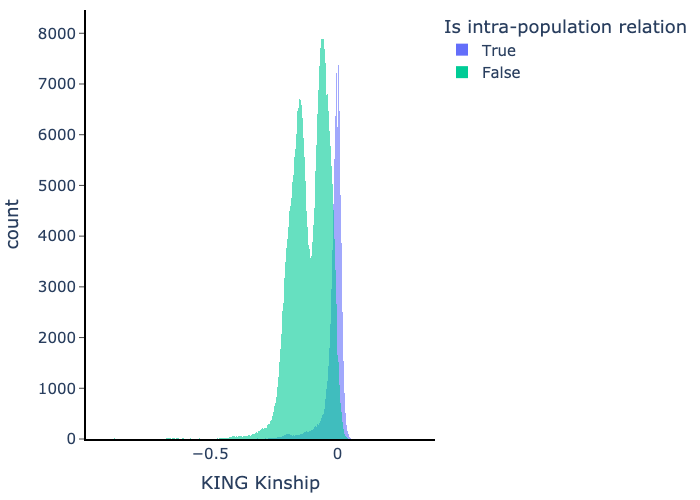

In [14]:
ip_melted = pd.melt(ip_df, id_vars=["K"],var_name="Pop", value_name='Is intra-population relation')

ip_melted = ip_melted[ip_melted["Pop"] == "Is_IP_Superpop"]

fig = px.histogram(ip_melted, x="K", color="Is intra-population relation", 
                   # facet_row="Pop", 
                   opacity=0.6)
fig.update_layout(barmode='overlay', xaxis_title="KING Kinship")
fig.write_image("images/king_ip_hist.pdf")
fig.show(renderer="png")

## Dimensionality reduction

In [7]:
umap_X = UMAP(n_components=2).fit_transform(X)
print(umap_X.shape)

umap_X_filled = UMAP(n_components=2).fit_transform(X_filled[:-1, 1:])
print(umap_X_filled.shape)

(2503, 2)
(2503, 2)


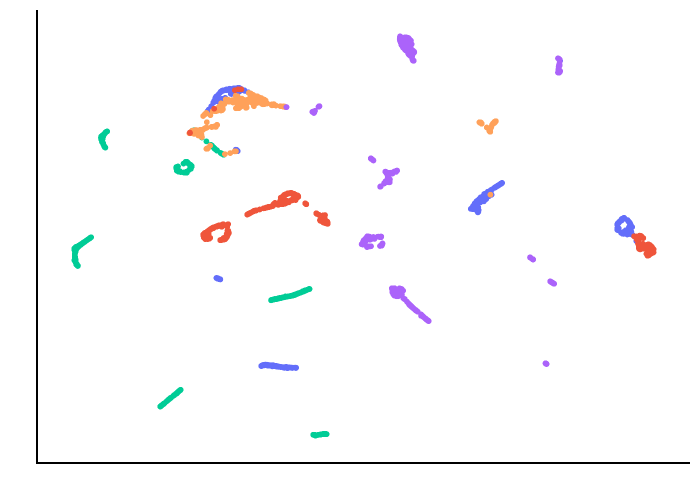

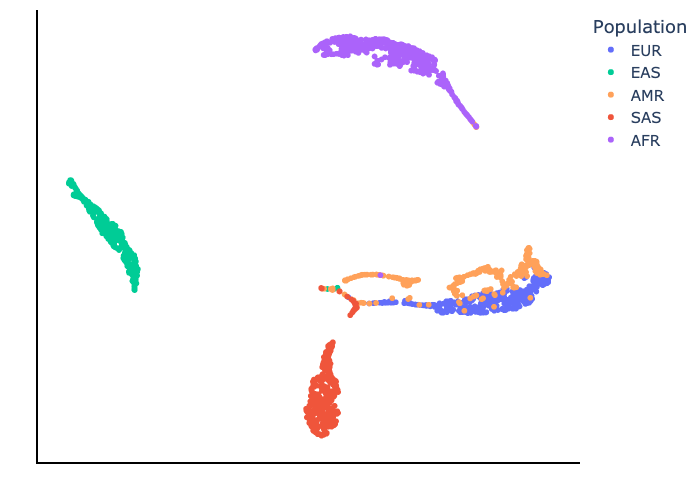

In [13]:
fig = px.scatter(x=umap_X[:, 0], y=umap_X[:, 1], color=label_superpops, 
                 # title="UMAP of KING matrix"
                )
fig.update_layout(legend_visible=False, xaxis=dict(title="", ticks="", showticklabels=False), yaxis=dict(title="", ticks="", showticklabels=False))
fig.write_image("images/umap_king.pdf")
fig.show()

fig = px.scatter(x=umap_X_filled[:, 0], y=umap_X_filled[:, 1], color=label_superpops, 
                 # title="UMAP on Filled KING matrix"
                )
fig.update_layout(legend_title="Population", xaxis=dict(title="", ticks="", showticklabels=False), yaxis=dict(title="", ticks="", showticklabels=False))
fig.write_image("images/umap_king_filled.pdf")
fig.show()

In [12]:
king_df.index

Index(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00107',
       ...
       'NA21127', 'NA21128', 'NA21129', 'NA21130', 'NA21133', 'NA21135',
       'NA21137', 'NA21141', 'NA21142', 'NA21143'],
      dtype='object', name='ID1', length=2503)

0
AFR    132
EAS    102
EUR    100
SAS     96
AMR     70
Name: count, dtype: int64 0
AFR    661
EAS    504
EUR    503
SAS    488
AMR    347
Name: count, dtype: int64


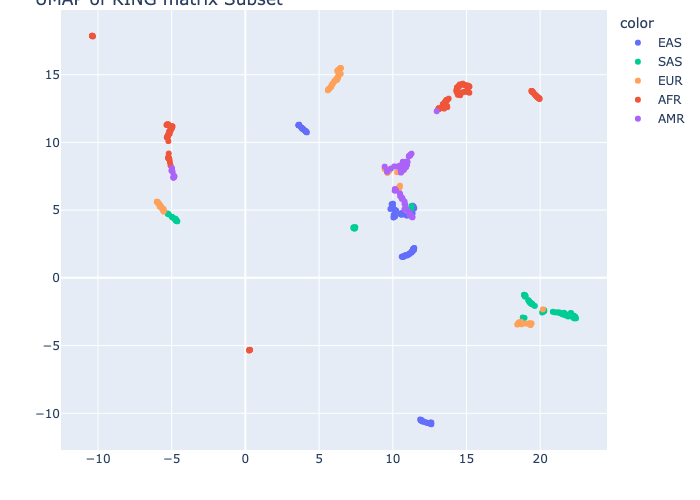

In [25]:
### Make even dist of 500 samples to investigate

king_subset_inds, _ = train_test_split(list(range(2503)), train_size=500, shuffle=True, stratify=label_codes)
print(label_superpops[king_subset_inds].value_counts(), label_superpops.value_counts())

umap_subset = UMAP(n_components=2).fit_transform(X[np.ix_(king_subset_inds, king_subset_inds)])
fig = px.scatter(x=umap_subset[:, 0], y=umap_subset[:, 1], color=label_superpops[king_subset_inds], 
                 title="UMAP of KING matrix Subset"
                )
fig.update_layout(legend_visible=True, xaxis_title="", yaxis_title="")
fig.show()

king_subset = sorted(king_df.iloc[king_subset_inds, :].index.tolist())
len(king_subset)

with open('../Data/1000genome_samples_subset.txt', 'w') as f:
    for k in king_subset:
        f.write(k)
        f.write("\n")

### Validation of KING clustering by dimensionality reduction on shuffled

Where we shuffle the person indices in the KING matrix (aka, don't sort by person name) and THEN reduce dimensions for plotting, to see if same general clusters formed. If yes, then clustering properly based on iter-relations. If not, then the clean pop clustering comes from the sorting of values and not from inherent relation in the KING matrix.

In [7]:
king_named = pd.read_csv("../Data/king_matrix_withnames.csv", index_col=0).fillna(0)
king_unpivot = king_named.melt(value_name="kinship", var_name="ID2", ignore_index=False)
king_unpivot = king_unpivot[king_unpivot["kinship"] != 0]
king_unpivot

,ID2,kinship
ID1,,
HG00096,HG00097,-0.0091
HG00096,HG00099,-0.0023
HG00097,HG00099,-0.0004
HG00096,HG00100,-0.0143
HG00097,HG00100,0.0173
...,...,...
NA21135,NA21144,-0.0013
NA21137,NA21144,-0.0230
NA21141,NA21144,0.0150


In [25]:
king_named_filled = king_named.copy()
king_named_filled.iloc[:, :] = X_filled[:-1, 1:]
king_unpivot_filled = king_named_filled.melt(value_name="kinship", var_name="ID2", ignore_index=False)
king_unpivot_filled = king_unpivot_filled[king_unpivot_filled["kinship"] != 0]
king_unpivot_filled
king_named_filled, king_unpivot_filled

(         HG00097  HG00099  HG00100  HG00101  HG00102  HG00103  HG00105  \
 ID1                                                                      
 HG00096  -0.0091  -0.0023  -0.0143   0.0077   0.0092  -0.0053  -0.0048   
 HG00097   0.0000  -0.0004   0.0173   0.0383   0.0283   0.0030   0.0314   
 HG00099  -0.0004   0.0000   0.0147   0.0277   0.0092   0.0093   0.0105   
 HG00100   0.0173   0.0147   0.0000   0.0399   0.0155  -0.0011   0.0134   
 HG00101   0.0383   0.0277   0.0399   0.0000   0.0344   0.0066   0.0117   
 ...          ...      ...      ...      ...      ...      ...      ...   
 NA21135  -0.0172  -0.0414  -0.0312  -0.0309  -0.0076  -0.0542  -0.0388   
 NA21137  -0.0325  -0.0451  -0.0362  -0.0345  -0.0287  -0.0428  -0.0293   
 NA21141  -0.0144  -0.0303  -0.0205  -0.0067  -0.0038  -0.0241  -0.0100   
 NA21142  -0.0066  -0.0347  -0.0278  -0.0162  -0.0157  -0.0312  -0.0226   
 NA21143   0.0074  -0.0333  -0.0235  -0.0113  -0.0176  -0.0327  -0.0157   
 
          HG00106  HG00

In [34]:
# Shuffle
king_shuff = king_unpivot.sample(frac=1)
king_shuff_mat = king_shuff.pivot_table(columns="ID2", values="kinship", index=king_shuff.index, dropna=False, sort=False)[king_shuff.index.unique().drop('HG00096').tolist()]
king_shuff_mat

king_shuff_filled = king_unpivot_filled.sample(frac=1)
king_shuff_mat_filled = king_shuff_filled.pivot_table(columns="ID2", 
                                                      values="kinship", 
                                                      index=king_shuff_filled.index, 
                                                      dropna=False, sort=False)[king_shuff_filled.index.unique().drop('HG00096').tolist()]
print(king_shuff_mat)
king_shuff_mat_filled

ID2      HG02810  HG00262  HG00625  HG02586  HG00560  HG02574  HG03039  \
ID1                                                                      
HG02810      NaN      NaN      NaN      NaN      NaN      NaN  -0.1895   
HG00262  -0.2217      NaN  -0.0424  -0.1373  -0.0708  -0.1563  -0.1510   
HG00625  -0.2550      NaN      NaN  -0.1525      NaN  -0.1667  -0.1754   
HG02586  -0.1854      NaN      NaN      NaN      NaN      NaN   0.0218   
HG00560  -0.2991      NaN  -0.0016  -0.2122      NaN  -0.2105  -0.2211   
...          ...      ...      ...      ...      ...      ...      ...   
NA21135      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
NA21130      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
NA21129      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
NA21143      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
NA21119      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

ID2      HG01697  HG01806  HG01977  .

ID2,NA12489,NA20356,HG00310,HG04100,HG03082,HG02332,NA19006,NA18916,HG02330,HG03805,...,HG02085,HG00123,HG02634,HG01626,HG03706,NA20888,HG02067,HG02396,HG01710,NA19184
ID1,,,,,,,,,,,,,,,,,,,,,
NA12489,NaN,-0.1044,0.0175,-0.0077,-0.1242,-0.1195,-0.0638,-0.1155,-0.1092,-0.0203,...,-0.0751,0.0305,-0.1072,0.0101,-0.0144,-0.0618,-0.0915,-0.0709,0.0399,-0.1195
NA20356,-0.1044,NaN,-0.1201,-0.1129,0.0125,0.0153,-0.1815,0.0155,0.0071,-0.1441,...,-0.1949,-0.1263,0.0089,-0.1291,-0.1177,-0.1793,-0.1986,-0.1876,-0.0875,0.0231
HG00310,0.0175,-0.1201,NaN,-0.0074,-0.1474,-0.1425,-0.0848,-0.1327,-0.1300,-0.0405,...,-0.0840,0.0223,-0.1431,-0.0255,-0.0235,-0.0717,-0.0910,-0.0928,0.0039,-0.1408
HG04100,-0.0077,-0.1129,-0.0074,NaN,-0.1403,-0.1305,-0.0702,-0.1211,-0.1085,-0.0194,...,-0.0689,-0.0221,-0.1325,-0.0288,-0.0088,-0.0445,-0.0749,-0.0811,-0.0019,-0.1320
HG03082,-0.1242,0.0125,-0.1474,-0.1403,NaN,0.0084,-0.2188,0.0078,-0.0096,-0.1636,...,-0.2125,-0.1415,-0.0097,-0.1570,-0.1439,-0.2183,-0.2146,-0.2299,-0.1238,0.0018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA20888,-0.0618,-0.1793,-0.0717,-0.0445,-0.2183,-0.2119,-0.0652,-0.2008,-0.1672,-0.0496,...,-0.0693,-0.0652,-0.2045,-0.0715,-0.0633,NaN,-0.0804,-0.0896,-0.0605,-0.2043
HG02067,-0.0915,-0.1986,-0.0910,-0.0749,-0.2146,-0.1997,-0.0116,-0.2060,-0.1887,-0.0573,...,-0.0251,-0.0998,-0.2194,-0.0756,-0.0916,-0.0804,NaN,-0.0096,-0.0890,-0.1962
HG02396,-0.0709,-0.1876,-0.0928,-0.0811,-0.2299,-0.2155,-0.0246,-0.2058,-0.1959,-0.0881,...,-0.0004,-0.0956,-0.2267,-0.1097,-0.0835,-0.0896,-0.0096,NaN,-0.0679,-0.2004


In [35]:
shuffled_pops = sample_to_popcode.set_index("Sample name").loc[king_shuff_mat.index.tolist()]["Population code"].reset_index(drop=True)
shuffled_superpops = sample_to_popcode.set_index("Sample name").loc[king_shuff_mat.index.tolist()]["Superpopulation code"].reset_index(drop=True)

shuffled_pops_filled = sample_to_popcode.set_index("Sample name").loc[king_shuff_mat_filled.index.tolist()]["Population code"].reset_index(drop=True)
shuffled_superpops_filled = sample_to_popcode.set_index("Sample name").loc[king_shuff_mat_filled.index.tolist()]["Superpopulation code"].reset_index(drop=True)

In [28]:
umap_X = UMAP(n_components=2).fit_transform(X)
print(umap_X.shape)

umap_X_filled = UMAP(n_components=2).fit_transform(X_filled[:-1, 1:])
print(umap_X_filled.shape)

umap_shuffled = UMAP(n_components=2).fit_transform(king_shuff_mat.fillna(0).to_numpy())
print(umap_shuffled.shape)

umap_shuffled_filled = UMAP(n_components=2).fit_transform(king_shuff_mat_filled.fillna(0).to_numpy())
print(umap_shuffled_filled.shape)

(2503, 2)
(2503, 2)
(2503, 2)
(2503, 2)


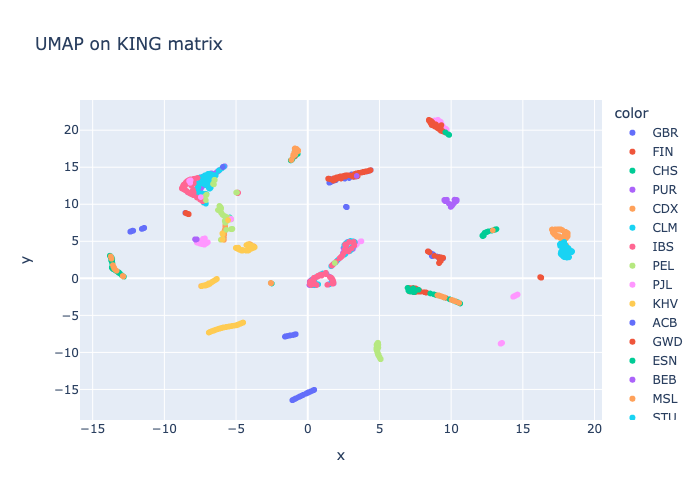

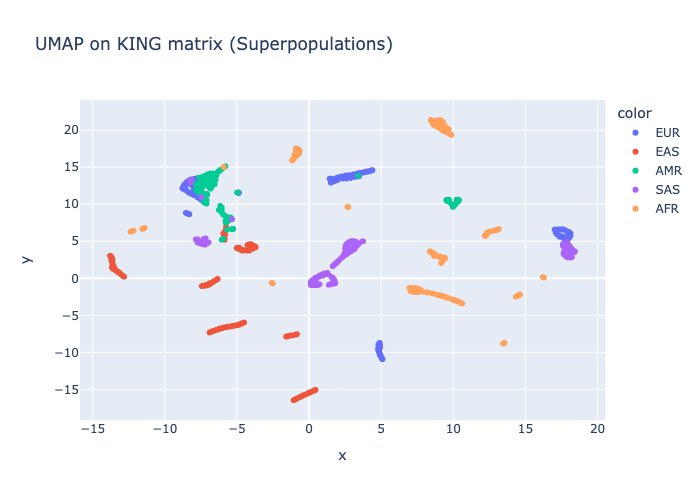

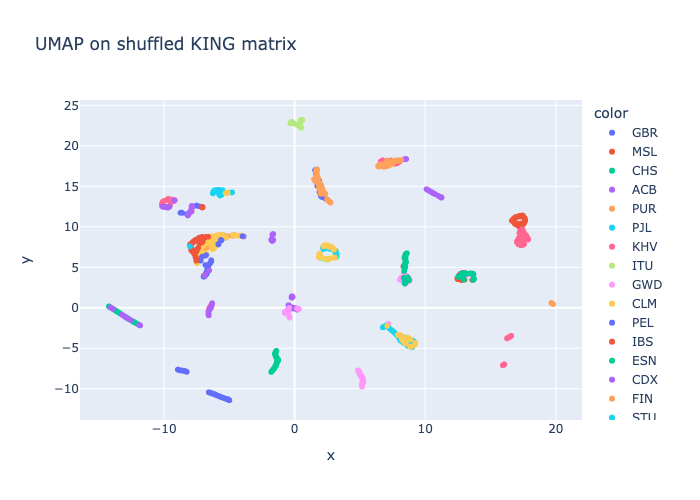

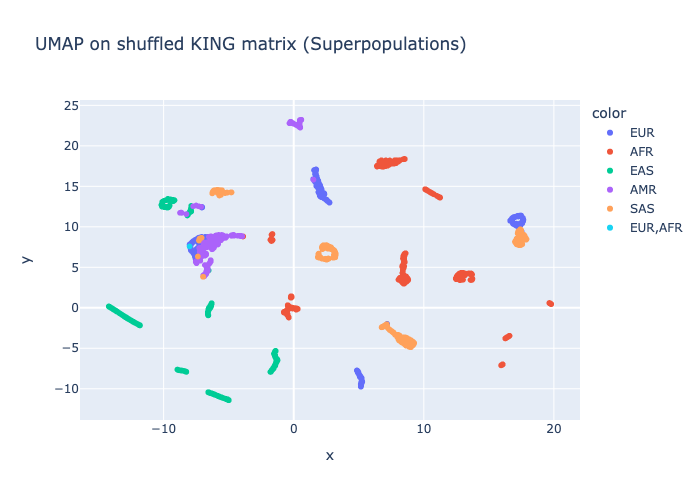

In [33]:
fig = px.scatter(x=umap_X[:, 0], y=umap_X[:, 1], color=label_codes, title="UMAP on KING matrix")
fig.show()

fig = px.scatter(x=umap_X[:, 0], y=umap_X[:, 1], color=label_superpops, title="UMAP on KING matrix (Superpopulations)")
fig.show()

fig = px.scatter(x=umap_shuffled[:, 0], y=umap_shuffled[:, 1], color=shuffled_pops, title="UMAP on shuffled KING matrix")
fig.show()

fig = px.scatter(x=umap_shuffled[:, 0], y=umap_shuffled[:, 1], color=shuffled_superpops, title="UMAP on shuffled KING matrix (Superpopulations)")
fig.show()

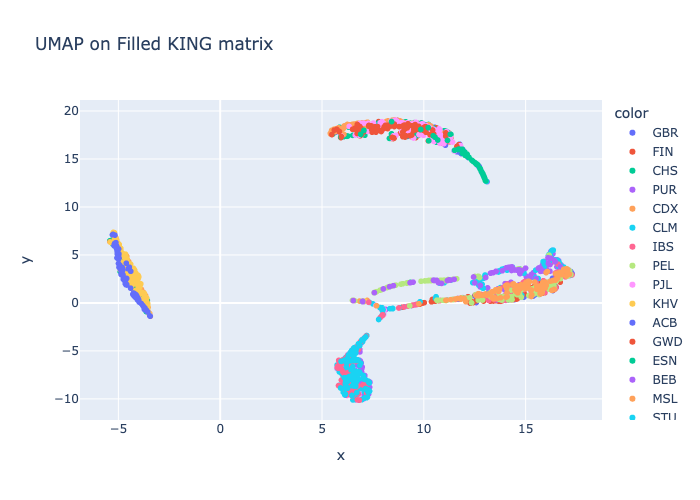

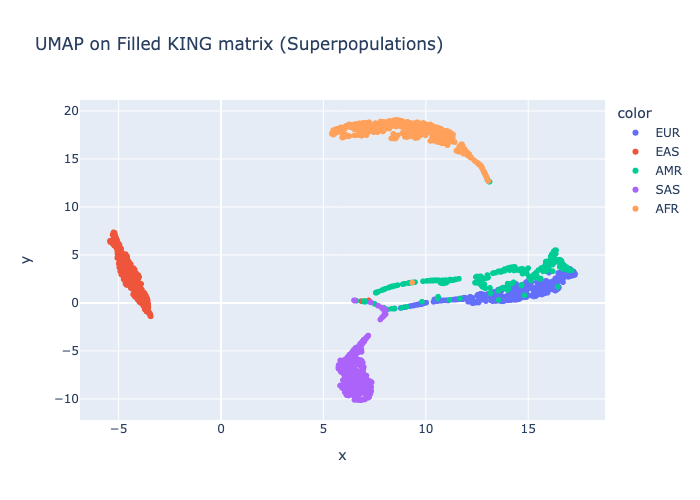

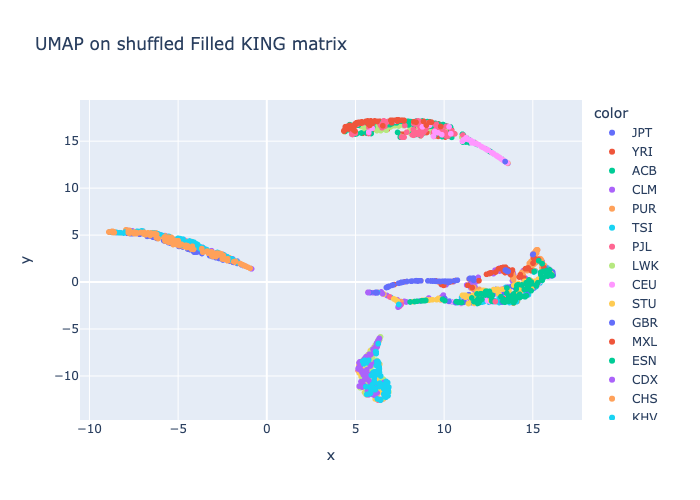

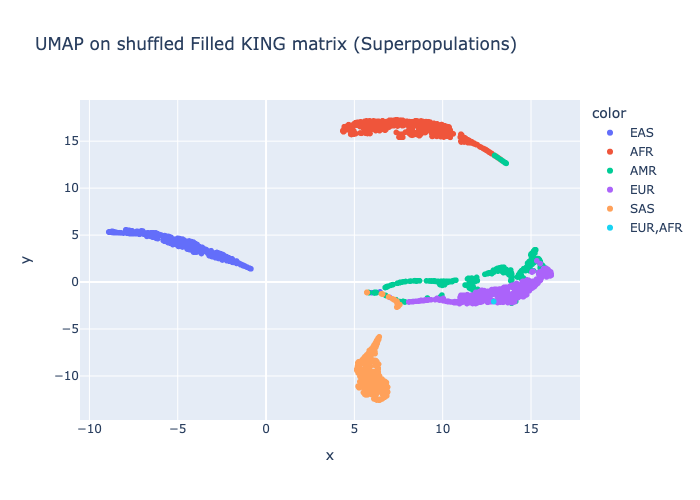

In [32]:
fig = px.scatter(x=umap_X_filled[:, 0], y=umap_X_filled[:, 1], color=label_codes, title="UMAP on Filled KING matrix")
fig.show()

fig = px.scatter(x=umap_X_filled[:, 0], y=umap_X_filled[:, 1], color=label_superpops, title="UMAP on Filled KING matrix (Superpopulations)")
fig.show()

fig = px.scatter(x=umap_shuffled_filled[:, 0], y=umap_shuffled_filled[:, 1], color=shuffled_pops_filled, title="UMAP on shuffled Filled KING matrix")
fig.show()

fig = px.scatter(x=umap_shuffled_filled[:, 0], y=umap_shuffled_filled[:, 1], color=shuffled_superpops_filled, title="UMAP on shuffled Filled KING matrix (Superpopulations)")
fig.show()